# Information Elements Categorical Embeddings

## Libraries and Configurations

Import configuration files

In [37]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [38]:
import pandas as pd

Import **ML libraries**

In [39]:
from sklearn import preprocessing
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models

Import **other libraries**

In [40]:
import numpy as np

from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x102bda490>>

Custom helper scripts

In [41]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


## Import Data

In [42]:
# Combined dataframe
combined_df_csv = config["DEFAULT"]["interim_path"] + "balanced_df_raw.csv"

In [43]:
df = pd.read_csv(combined_df_csv, index_col=0)

Keeping only categorical columns to be encoded

In [44]:
df = df[["HT Capabilities", "Extended Capabilities", "Vendor Specific Tags", "Label"]]

In [45]:
df

,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Label
0,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
1,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
2,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
3,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
4,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
...,...,...,...,...
13939,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13940,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13941,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13942,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S


In [46]:
df = df.rename(
    columns={
        "HT Capabilities": "HT_Capabilities",
        "Extended Capabilities": "Extended_Capabilities",
        "Vendor Specific Tags": "Vendor_Specific_Tags",
    }
)

In [47]:
label_encoder = preprocessing.LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

Selecting categorical features

In [48]:
features = [f for f in df.columns if f != "Label"]

In [49]:
features

['HT_Capabilities', 'Extended_Capabilities', 'Vendor_Specific_Tags']

## Label Encoding

In [50]:
for feat in features:
    encoder = preprocessing.LabelEncoder()
    df.loc[:, feat] = encoder.fit_transform(df[feat].astype(str).fillna("-1").values)

In [51]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


In [52]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


## Entity Embedding

Splitting `df` into train and test set

In [53]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [54]:
X_train.shape, X_test.shape

((28836, 3), (7210, 3))

In [55]:
def get_model(
    df: pd.DataFrame, categorical_columns: str, embed_dim: int
) -> models.Model:
    inputs = []
    outputs = []

    for c in categorical_columns:
        num_unique_values = int(df[c].nunique())
        if embed_dim is None:
            embed_dim = int(min(np.ceil((num_unique_values) / 2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.Reshape(target_shape=(embed_dim,))(out)
        inputs.append(inp)
        outputs.append(out)

    x = layers.Concatenate()(outputs)
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    y = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=y)

    return model

In [56]:
model = get_model(X_train, features, 10)
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.Adam(0.001), metrics=["mae"]
)

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 HT_Capabilities (Embedding  (None, 1, 10)                240       ['input_4[0][0]']             
 )                                                                                          

In [58]:
x = [X_train.loc[:, f].values for f in features]

x = [np.asarray(x[i]).astype("float32") for i in range(len(x))]

x

[array([13., 19., 22., ..., 12., 11., 13.], dtype=float32),
 array([19.,  5., 25., ..., 23., 19., 19.], dtype=float32),
 array([62., 18., 26., ...,  1., 62., 62.], dtype=float32)]

In [59]:
xt = [X_test.loc[:, f].values for f in features]

xt = [np.asarray(xt[i]).astype("float32") for i in range(len(xt))]

xt

[array([ 4.,  8., 12., ..., 13., 17., 11.], dtype=float32),
 array([11.,  7., 23., ..., 19.,  0., 19.], dtype=float32),
 array([62., 25.,  1., ..., 62.,  3., 62.], dtype=float32)]

In [60]:
ie_fit = model.fit(
    x,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(xt, y_test),
)

Epoch 1/50


902/902 [==============================] - 4s 3ms/step - loss: -19426950.0000 - mae: 14.0385 - val_loss: -99124808.0000 - val_mae: 14.1226
Epoch 2/50
902/902 [==============================] - 2s 2ms/step - loss: -542515712.0000 - mae: 14.0289 - val_loss: -1323362048.0000 - val_mae: 14.1226
Epoch 3/50
902/902 [==============================] - 2s 2ms/step - loss: -3009226240.0000 - mae: 14.0289 - val_loss: -5353601024.0000 - val_mae: 14.1226
Epoch 4/50
902/902 [==============================] - 2s 2ms/step - loss: -9072355328.0000 - mae: 14.0289 - val_loss: -13810810880.0000 - val_mae: 14.1226
Epoch 5/50
902/902 [==============================] - 2s 2ms/step - loss: -20306542592.0000 - mae: 14.0289 - val_loss: -28256229376.0000 - val_mae: 14.1226
Epoch 6/50
902/902 [==============================] - 2s 2ms/step - loss: -38227648512.0000 - mae: 14.0289 - val_loss: -50289930240.0000 - val_mae: 14.1226
Epoch 7/50
902/902 [==============================] - 2s 2ms/step - loss: -64511594496.

In [61]:
model.save(config["DEFAULT"]["models_path"] + "IE_embeddings.h5")

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
import matplotlib.pyplot as plt

In [63]:
ie_fit.history

{'loss': [-19426950.0,
  -542515712.0,
  -3009226240.0,
  -9072355328.0,
  -20306542592.0,
  -38227648512.0,
  -64511594496.0,
  -100995686400.0,
  -149483995136.0,
  -211694387200.0,
  -290098184192.0,
  -386614394880.0,
  -503774478336.0,
  -643604414464.0,
  -808452554752.0,
  -1001439887360.0,
  -1224554184704.0,
  -1480705048576.0,
  -1774486290432.0,
  -2108059549696.0,
  -2484222820352.0,
  -2906878115840.0,
  -3369022259200.0,
  -3896832688128.0,
  -4471265951744.0,
  -5112484855808.0,
  -5811595116544.0,
  -6587277639680.0,
  -7422335778816.0,
  -8336229007360.0,
  -9336819548160.0,
  -10433371045888.0,
  -11575273455616.0,
  -12854355820544.0,
  -14209814364160.0,
  -15660779307008.0,
  -17238209855488.0,
  -18911720374272.0,
  -20686517043200.0,
  -22616324702208.0,
  -24657554046976.0,
  -26847255461888.0,
  -29149875929088.0,
  -31591906672640.0,
  -34201302728704.0,
  -36900345741312.0,
  -39847116931072.0,
  -42961626726400.0,
  -46168826445824.0,
  -49705983672320.0],
 

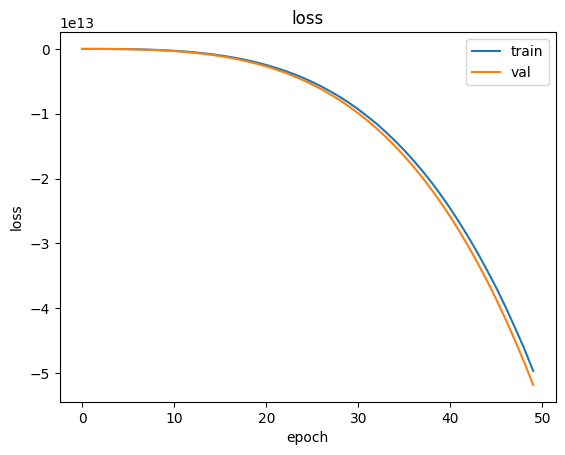

In [64]:
# summarize history for loss
plt.plot(ie_fit.history["loss"])
plt.plot(ie_fit.history["val_loss"])
plt.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")

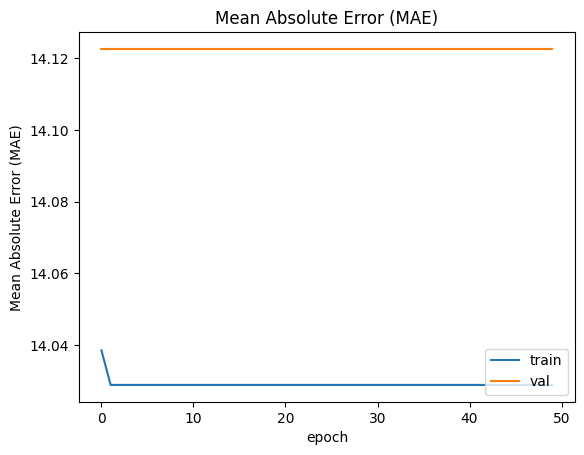

In [65]:
# summarize history for mae
plt.plot(ie_fit.history["mae"])
plt.plot(ie_fit.history["val_mae"])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="lower right")
plt.show()

In [66]:
import seaborn as sns

226/226 [==============================] - 0s 917us/step


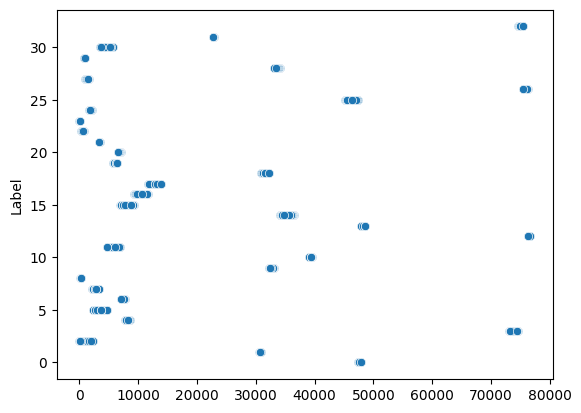

In [67]:
# Make prediction
y_test_predict = model.predict(xt)

# Change the predictions from 2-d to 1-d
y_test_predict = y_test_predict.flatten()

# Visualization
ax = sns.scatterplot(y_test)

In [68]:
# Import library
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f"The MSE for the model is {MSE:.2f}")
print(f"The RMSE for the model is {RMSE:.2f}.")
print(f"The MAE for the model is {MAE:.2f}.")
print(f"The R-squared for the model is {R2:.2f}.")
print(f"The MAPE for the model is {MAPE:.2f}.")

The MSE for the model is 278.55
The RMSE for the model is 16.69.
The MAE for the model is 14.12.
The R-squared for the model is -2.49.
The MAPE for the model is 61838607920899.50.


In [69]:
model.get_layer("Vendor_Specific_Tags").get_weights()

[array([[ 3.38862190e+01,  3.38588448e+01,  3.38236961e+01,
          3.38755646e+01, -3.38883972e+01,  3.38428307e+01,
         -3.38065567e+01, -3.37913551e+01, -3.38734932e+01,
          3.38857307e+01],
        [ 4.27489929e+01,  4.27882462e+01,  4.27630653e+01,
          4.28018456e+01, -4.28239861e+01,  4.27641335e+01,
         -4.28168869e+01, -4.27910919e+01, -4.27540207e+01,
          4.27814217e+01],
        [ 8.21817112e+00,  8.17739391e+00,  8.16762733e+00,
          8.19338608e+00, -8.16877174e+00,  8.22812557e+00,
         -8.24599075e+00, -8.23085880e+00, -8.17952156e+00,
          8.23668480e+00],
        [ 4.80670242e+01,  4.80144997e+01,  4.79566765e+01,
          4.80756035e+01, -4.80045090e+01,  4.79970512e+01,
         -4.80597343e+01, -4.79788971e+01, -4.80079956e+01,
          4.80186958e+01],
        [ 2.66296310e+01,  2.66861057e+01,  2.67062988e+01,
          2.66124802e+01, -2.66463604e+01,  2.66058788e+01,
         -2.66358814e+01, -2.66458397e+01, -2.669789

In [70]:
# Get weights from the embedding layer
cat_emb_df = pd.DataFrame(
    model.get_layer("Vendor_Specific_Tags").get_weights()[0]
).reset_index()

# Add prefix to the embedding names
cat_emb_df = cat_emb_df.add_prefix("Vendor_Specific_Tags_")

# Take a look at the data
cat_emb_df

,Vendor_Specific_Tags_index,Vendor_Specific_Tags_0,Vendor_Specific_Tags_1,Vendor_Specific_Tags_2,Vendor_Specific_Tags_3,Vendor_Specific_Tags_4,Vendor_Specific_Tags_5,Vendor_Specific_Tags_6,Vendor_Specific_Tags_7,Vendor_Specific_Tags_8,Vendor_Specific_Tags_9
0,0,33.886219,33.858845,33.823696,33.875565,-33.888397,33.842831,-33.806557,-33.791355,-33.873493,33.885731
1,1,42.748993,42.788246,42.763065,42.801846,-42.823986,42.764133,-42.816887,-42.791092,-42.754021,42.781422
2,2,8.218171,8.177394,8.167627,8.193386,-8.168772,8.228126,-8.245991,-8.230859,-8.179522,8.236685
3,3,48.067024,48.014500,47.956676,48.075603,-48.004509,47.997051,-48.059734,-47.978897,-48.007996,48.018696
4,4,26.629631,26.686106,26.706299,26.612480,-26.646360,26.605879,-26.635881,-26.645840,-26.697893,26.697639
...,...,...,...,...,...,...,...,...,...,...,...
59,59,-19.014780,-18.967190,-19.004238,-18.977507,18.939037,-18.995245,18.989408,19.040306,18.979126,-18.977619
60,60,-0.007559,-0.009533,0.011262,-0.043638,0.017555,-0.049414,-0.041692,-0.044506,-0.005868,-0.019970
61,61,1.316919,1.255541,1.271401,1.330853,-1.247765,1.250629,-1.273280,-1.241754,-1.295525,1.273114
62,62,52.034073,51.958614,51.996212,51.963749,-52.028141,52.028419,-51.970612,-52.003605,-52.029709,52.003399


In [71]:
# Get weights from the embedding layer
ht_emb_df = pd.DataFrame(
    model.get_layer("HT_Capabilities").get_weights()[0]
).reset_index()

# Add prefix to the embedding names
ht_emb_df = ht_emb_df.add_prefix("HT_Capabilities_")

# Take a look at the data
ht_emb_df

,HT_Capabilities_index,HT_Capabilities_0,HT_Capabilities_1,HT_Capabilities_2,HT_Capabilities_3,HT_Capabilities_4,HT_Capabilities_5,HT_Capabilities_6,HT_Capabilities_7,HT_Capabilities_8,HT_Capabilities_9
0,0,-44.939720,-44.866966,-44.894279,44.987911,-44.964725,44.915237,-45.002743,44.974007,44.962002,-44.950462
1,1,-33.808868,-33.789505,-33.853828,33.879925,-33.884403,33.863453,-33.813972,33.893723,33.811081,-33.894886
2,2,-44.820915,-44.877079,-44.898567,44.893120,-44.933174,44.926392,-44.835129,44.801258,44.870365,-44.903053
3,3,-34.777962,-34.872395,-34.888535,34.881626,-34.887589,34.844460,-34.866333,34.823929,34.886322,-34.839802
4,4,-41.563843,-41.481907,-41.544415,41.520443,-41.475754,41.504410,-41.571739,41.494541,41.482624,-41.566559
5,5,-16.390093,-16.462280,-16.467646,16.394753,-16.391520,16.458424,-16.402554,16.423624,16.457701,-16.371611
6,6,-26.063030,-26.013052,-26.044352,26.059000,-26.018394,26.082685,-26.047203,25.976763,25.989689,-26.079531
7,7,-17.495230,-17.552099,-17.450489,17.545128,-17.485395,17.538885,-17.533520,17.510714,17.481157,-17.473057
8,8,-44.881302,-44.878456,-44.805576,44.875366,-44.758137,44.848385,-44.845188,44.757267,44.849644,-44.835930
9,9,-29.823437,-29.862476,-29.819132,29.832928,-29.822565,29.851135,-29.823690,29.883881,29.819395,-29.885351


In [72]:
# Get weights from the embedding layer
extended_emb_df = pd.DataFrame(
    model.get_layer("Extended_Capabilities").get_weights()[0]
).reset_index()

# Add prefix to the embedding names
extended_emb_df = extended_emb_df.add_prefix("Extended_Capabilities_")

# Take a look at the data
extended_emb_df

,Extended_Capabilities_index,Extended_Capabilities_0,Extended_Capabilities_1,Extended_Capabilities_2,Extended_Capabilities_3,Extended_Capabilities_4,Extended_Capabilities_5,Extended_Capabilities_6,Extended_Capabilities_7,Extended_Capabilities_8,Extended_Capabilities_9
0,0,44.729240,-44.732758,-44.645348,-44.634026,44.635296,44.613796,44.712429,44.697025,-44.708267,-44.749958
1,1,41.717510,-41.637230,-41.718792,-41.644772,41.640839,41.701069,41.624214,41.658123,-41.673260,-41.713318
2,2,22.323229,-22.290064,-22.353601,-22.275099,22.347717,22.249876,22.354902,22.267870,-22.252136,-22.272942
3,3,9.175531,-9.152000,-9.219727,-9.159475,9.142676,9.211152,9.188396,9.152047,-9.164351,-9.209970
4,4,44.115776,-44.048107,-44.071686,-44.030151,44.081367,44.115688,44.072979,44.087219,-44.063965,-44.124584
5,5,37.608158,-37.555859,-37.517139,-37.540447,37.583397,37.619492,37.615730,37.617290,-37.587566,-37.581329
6,6,4.719382,-4.764742,-4.765855,-4.791891,4.791718,4.716895,4.722727,4.738928,-4.748397,-4.800554
7,7,44.800701,-44.717327,-44.805065,-44.801296,44.827202,44.719269,44.785538,44.760601,-44.744694,-44.803013
8,8,26.562366,-26.579704,-26.533665,-26.539835,26.461794,26.460039,26.522612,26.511299,-26.545277,-26.570299
9,9,36.683510,-36.771927,-36.716637,-36.694786,36.674767,36.673862,36.704548,36.784847,-36.767582,-36.701893
